# `Challenge Deep Learning`

## `Consigne`

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test.

Le notebook sera déposé sur la plateforme moodle du cours.

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from PIL import Image

In [52]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## `Pré-traitement des données`


In [31]:
import pathlib

path = "datasets/mushrooms"
dset_dir = pathlib.Path(path)
image_count = len(list(dset_dir.glob('*/*.jpg')))
print(f"Nombre d'images : {image_count}")

Nombre d'images : 1643


In [32]:
batch_size = 16
img_height = 224
img_width  = 224

In [34]:
train_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1643 files belonging to 3 classes.
Using 1315 files for training.


In [35]:
val_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1643 files belonging to 3 classes.
Using 328 files for validation.


In [36]:
class_names = train_dset.class_names
print(class_names)

['amanita', 'crimini', 'oyster']


2025-01-07 15:25:52.443434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


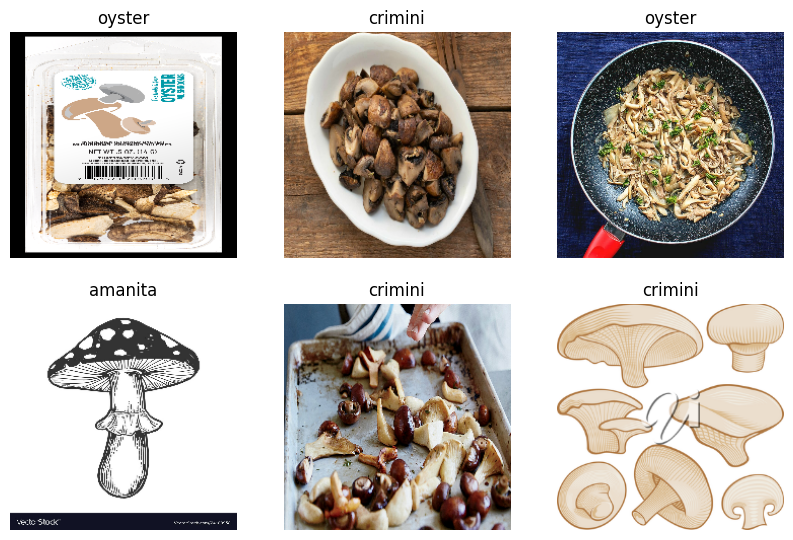

In [41]:
plt.figure(figsize=(10,10))
for images, labels in train_dset.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# `Modèle de réseaux de neurones`


## ``ResNet50``
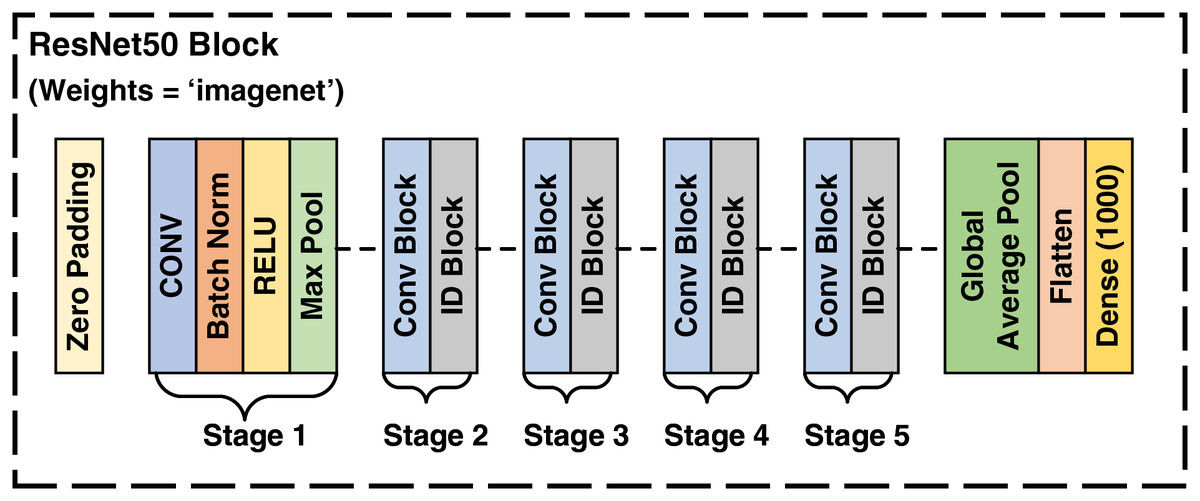

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_dset = train_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dset = val_dset.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_dset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

2025-01-07 15:25:58.595064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-01-07 15:25:59.461330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-01-07 15:25:59.866988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


0.0 1.0


In [45]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3)
])

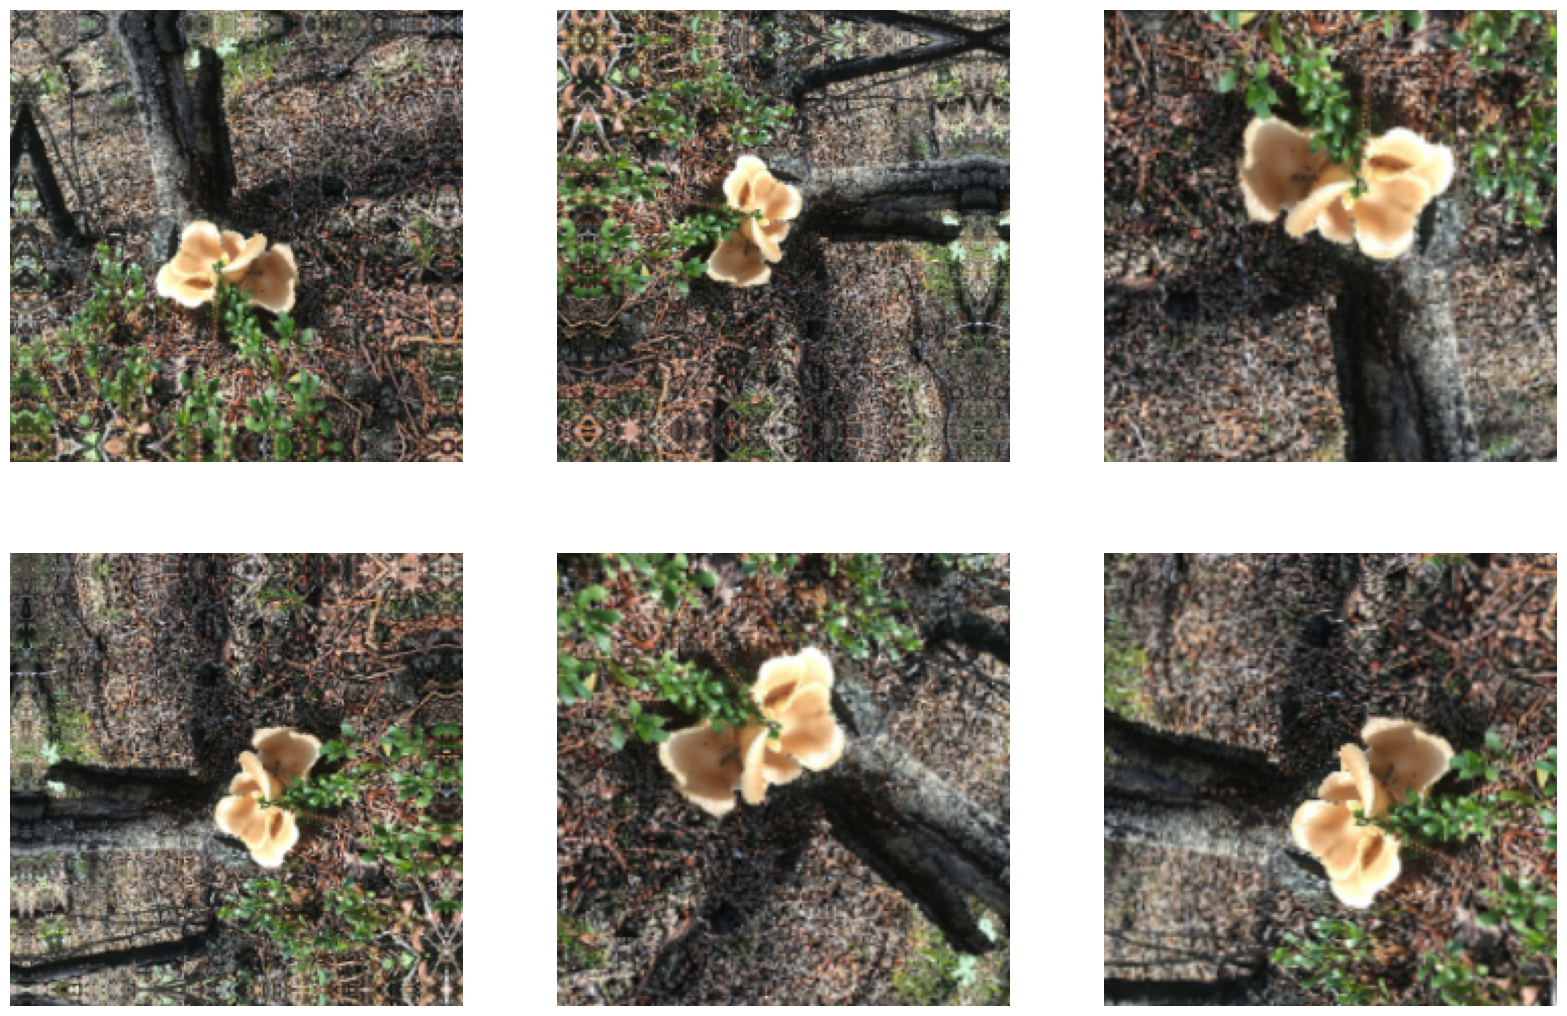

In [46]:
plt.figure(figsize=(20,20))
for images, _ in train_dset.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [57]:
num_classes = len(class_names)

resnet_model = ResNet50(weights="imagenet")

last_layer = resnet_model.get_layer("avg_pool")
resnet_layers = Model(inputs=resnet_model.inputs, outputs=last_layer.output)

model = Sequential()
model.add(data_augmentation)
model.add(resnet_layers)
model.add(Dense(num_classes))

model.layers[0].trainable = False

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [61]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model(ResNet50).keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)


In [63]:
epochs = 10
history = model.fit(
    train_dset,
    validation_data=val_dset,
    epochs=epochs,
    callbacks=[checkpoint, early, reduce_lr],
)acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.title('Validation Loss')
plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.title('Validation Loss')
plt.show()


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8908 - loss: 0.3031
Epoch 1: val_accuracy improved from -inf to 0.85061, saving model to Model(ResNet50).keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.8906 - loss: 0.3034 - val_accuracy: 0.8506 - val_loss: 0.4151 - learning_rate: 1.0000e-04
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9164 - loss: 0.2001
Epoch 2: val_accuracy did not improve from 0.85061
83/83 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9165 - loss: 0.2002 - val_accuracy: 0.7591 - val_loss: 1.2955 - learning_rate: 1.0000e-04
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9619 - loss: 0.1156
Epoch 3: val_accuracy improved from 0.85061 to 0.85976, saving model to Model(ResNet50).keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9618 - loss: 0.1156 - val_accuracy: 0.8598 - val_loss: 0.5216 - learning_rate: 1.0000e-04
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9436 - loss: 0.1430


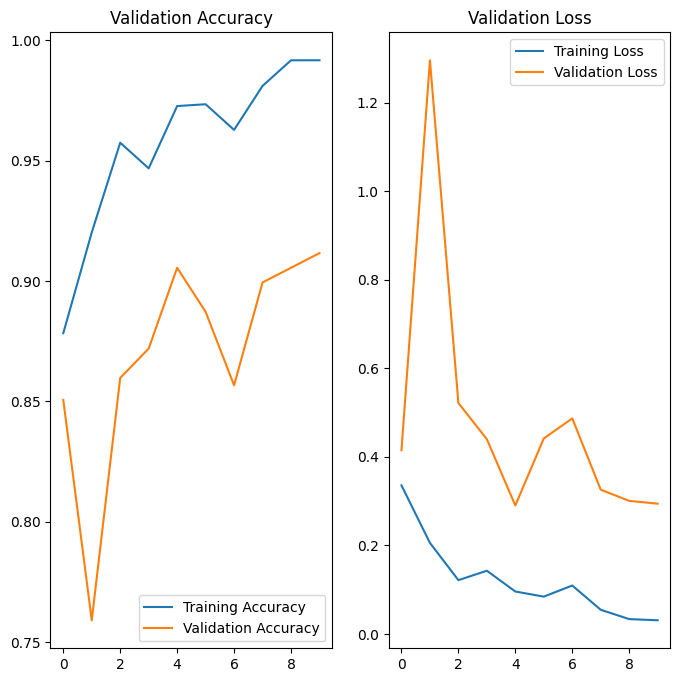

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.title('Validation Loss')
plt.show()
